# Dataset and Library Loading

In [14]:
# Load some basic packages and set plot style 
import numpy                   as np
import pandas                  as pd 
import seaborn                 as sns
import matplotlib.pyplot       as plt
plt.style.use('ggplot')                
from   collections             import Counter

# Pytorch Packages
import torch
import torch.nn                as nn
from   torch.nn                import functional as F
from   torch.autograd          import Variable

# Sci-Kit packages
from   sklearn.utils           import shuffle
from   sklearn.preprocessing   import StandardScaler
from   sklearn.linear_model    import LogisticRegression
from   sklearn.model_selection import train_test_split

# Load Data using Pandas
df_train = pd.read_csv('../input/titanic/train.csv')
df_test  = pd.read_csv('../input/titanic/test.csv')
df_sub   = pd.read_csv('../input/titanic/gender_submission.csv')

# Preprocessing Datasets

## 1. Redundant variables are identified and dropped

   * Columns identified were PassengerId (identical to index values) , Name (self explanatory), Ticket and Cabin (too many null values) <br>
   
   
## 2. One-Hot Encoding of Categorical Variables

   * Sex and Location of Embarkation are categorical values that cannot be processed immediately by a model
   * One-Hot Encoding is peformed on the categorical values in the train and test data  <br>
   
   
## 3. Impute (filling in missing data using suitable value) necessary columns 

   * Columns with missing data are imputed with the mean values of said column <br>
   
   
## 4. Feature Engineering

   *     Combining SibSp and Parch into a single new variable, Family
   *     Drop the redundant SibSp and Parch <br>
     
     
## 5. Scaling Train and Test Data

   *     Scaling performed due to the varying orders of magnitude in the input variables <br>
   
   
## 6. Random Shuffle and Split Dataset

   *     Shuffle the entire test data set
   *     Split test data into X and Y variables <br>

In [15]:
# Dropping redundant values
df_train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)
df_test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

In [16]:
# "Sex" and "Embarked" are the categorical data, one-hot encoding is needed
# "sex" and "embark" are the encoded data
# drop_first=True to reduce size of encoded data (reducing memory usage, more important for large datasets)
# Original columns now redundant and are dropped and encoded data iare concatenated back into dataframe

sex      = pd.get_dummies(df_train['Sex'],drop_first=True)
embark   = pd.get_dummies(df_train['Embarked'],drop_first=True)
df_train = pd.concat([df_train,sex,embark],axis=1)
df_train.drop(['Sex','Embarked'],axis=1,inplace=True)

sex     = pd.get_dummies(df_test['Sex'],drop_first=True)
embark  = pd.get_dummies(df_test['Embarked'],drop_first=True)
df_test = pd.concat([df_test,sex,embark],axis=1)
df_test.drop(['Sex','Embarked'],axis=1,inplace=True)

In [17]:
# df_train.info()
# df_test.info()
# Age has null values still unfilled
# Age and Fare has null values still unfilled

df_train.fillna(df_train.mean(),inplace=True)
df_test.fillna(df_test.mean(),inplace=True)

In [18]:
#SibSp and Parch are merged into a new variable called Family

df_train['Family'] = df_train['SibSp']+df_train['Parch']          # Combine values in SibSp and Parch
df_train.loc[df_train['Family'] > 0, 'Family']  = 1               # Conditional statements to check if passenger had family members 
df_train.loc[df_train['Family'] == 0, 'Family'] = 0 
df_train.drop(['SibSp','Parch'],axis=1,inplace=True)              # Drop now redundant variables SibSp and Parch

df_test['Family'] = df_test['SibSp']+df_test['Parch']             # Repeat on Test dataset
df_test.loc[df_test['Family'] > 0, 'Family']  = 1 
df_test.loc[df_test['Family'] == 0, 'Family'] = 0 
df_test.drop(['SibSp','Parch'],axis=1,inplace=True)

In [19]:
Scaler1 = StandardScaler()                                  # Instantiate StandardScalar objects
Scaler2 = StandardScaler()

train_columns = df_train.columns                            # Store column names from train and test as scaling removes them
test_columns  = df_test.columns                             # Scaling removes the column headers
 
df_train = pd.DataFrame(Scaler1.fit_transform(df_train))    # Perform scaling
df_test  = pd.DataFrame(Scaler2.fit_transform(df_test))     

df_train.columns = train_columns                            # Reassign column headers
df_test.columns  = test_columns 

In [20]:
# Shuffle rows

df_train = df_train.sample(frac=1,axis=0,random_state=42).reset_index(drop=True) # drop=True to drop new default index 

# Assign X training values and Y training values
X_train  = df_train.iloc[:,1:].values
Y_train  = df_train.loc[:, 'Survived'].values


# Building Neural Network with PyTorch
  

## 1. Model Definition and Instantiation 

   * Model is a simple deep neural network comprising of 2 hidden layers, each containing 512 neurons <br>
   
   
## 2. Loss Function and Optimizer Function

   * Cross Entropy Loss is a suitable loss function for a classification problem 
   * Optimizer is set as Stochastic Gradient Descent with a learning rate of 0.03 
   
## 3. Training

   * Mini-batch gradient descent is chosen as the training method. Batch Size = 15 with 500 epochs  <br>
   
   
## 4. Prediction and Submission

   * Prediction using the test data and the results are saved into "submission.csv" <br>
   
   

In [21]:
class Net(nn.Module):                             
    
    def __init__(self):
        
        super(Net,self).__init__()          
        self.fc1     = nn.Linear(7,512)     # Input layer with 7 neurons (7 input variables)
        self.fc2     = nn.Linear(512,512)   # 2 Hidden Layers containing 512 neurons each
        self.fc3     = nn.Linear(512,2)     # Output layer with 2 neurons  
        self.dropout = nn.Dropout(0.5)      # Dropout rate of neurons set at standard 0.5 (50%)
        
    def forward(self,x):                    # Forward Propagation Definition with Rectified Linear Unit (relu) activ function
        x = F.relu(self.fc1(x))             # Input Layer    --> Hidden Layer 1
        x = self.dropout(x)                 # Dropout for Hidden Layer 1
        x = F.relu(self.fc2(x))             # Hidden Layer 1 --> Hidden Layer 2
        x = self.dropout(x)                 # Dropout for Hidden Layer 2
        x = self.fc3(x)                     # Hidden 2       --> Output
        return x
    
model = Net()                               # Instantiate an NN object
print(model)                                # Print parameters of NN object

Net(
  (fc1): Linear(in_features=7, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [22]:
criterion = nn.CrossEntropyLoss()                          # Loss Criterion set as Cross Entropy Loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.03)    # Optimiser set as Stochastic Gradient Descent

In [23]:
# Perform Mini-batch Gradient Descent
# Batch size is parameter to be tuned

batch_size = 30
n_epochs   = 750
batch_no   = len(X_train) // batch_size                             

losses     = []
train_loss = 0
train_loss_min = np.Inf

for epoch in range(n_epochs):                                    
    for i in range(batch_no):                                           
        
        #Define mini-batches
        
        start = i * batch_size
        end   = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train[start:end]))  
        y_var = Variable(torch.LongTensor(Y_train[start:end])) 
        
        #Training and Back propagation
        
        optimizer.zero_grad()                                       # Zeroes the gradient
        output = model(x_var)                                       # Model Training and Output
        loss   = criterion(output,y_var)                            # Calculate loss average by batch size
        loss.backward()                                             # Propagate Loss Backwards
        optimizer.step()                    
        
        #Calculating the accuracy
        
        values,labels = torch.max(output,1)
        num_right     = np.sum(labels.data.numpy() == y_var.numpy())# Compares the output results against the known y values
        train_loss   += loss.item()                                 # Sums up averaged losses per batch 
        
    train_loss = train_loss / batch_no                              # train_loss for that epoch is averaged by number of batches
    
    if train_loss <= train_loss_min:
        
        print("Validation loss decreased ({:6f} ===> {:6f}) from Epoc {} to {}".format(train_loss_min,train_loss,epoch-1,epoch))
        train_loss_min = train_loss
        
    if epoch % 200==0:
        
        print('')
        print("Epoch: {} \tTrain Loss: {:6f} \tTrain Accuracy: {:6f}".format(epoch+1, train_loss,num_right / len(Y_train[start:end]) ))
        
    losses.append(train_loss)
print('\nTraining Ended!\nFinal training loss is : {:6f} \nFinal Accuracy is : {:6f}'.format(losses[-1],num_right / len(Y_train[start:end])))
print("Saving the model...")
torch.save(model.state_dict(), "model.pt")
print("Model saved!")

Validation loss decreased (   inf ===> 0.601553) from Epoc -1 to 0

Epoch: 1 	Train Loss: 0.601553 	Train Accuracy: 0.933333
Validation loss decreased (0.601553 ===> 0.527627) from Epoc 0 to 1
Validation loss decreased (0.527627 ===> 0.505183) from Epoc 1 to 2
Validation loss decreased (0.505183 ===> 0.501128) from Epoc 2 to 3
Validation loss decreased (0.501128 ===> 0.492884) from Epoc 3 to 4
Validation loss decreased (0.492884 ===> 0.492375) from Epoc 5 to 6
Validation loss decreased (0.492375 ===> 0.477956) from Epoc 6 to 7
Validation loss decreased (0.477956 ===> 0.476040) from Epoc 8 to 9
Validation loss decreased (0.476040 ===> 0.473740) from Epoc 9 to 10
Validation loss decreased (0.473740 ===> 0.464893) from Epoc 10 to 11
Validation loss decreased (0.464893 ===> 0.463247) from Epoc 14 to 15
Validation loss decreased (0.463247 ===> 0.462997) from Epoc 16 to 17
Validation loss decreased (0.462997 ===> 0.461805) from Epoc 18 to 19
Validation loss decreased (0.461805 ===> 0.456293)

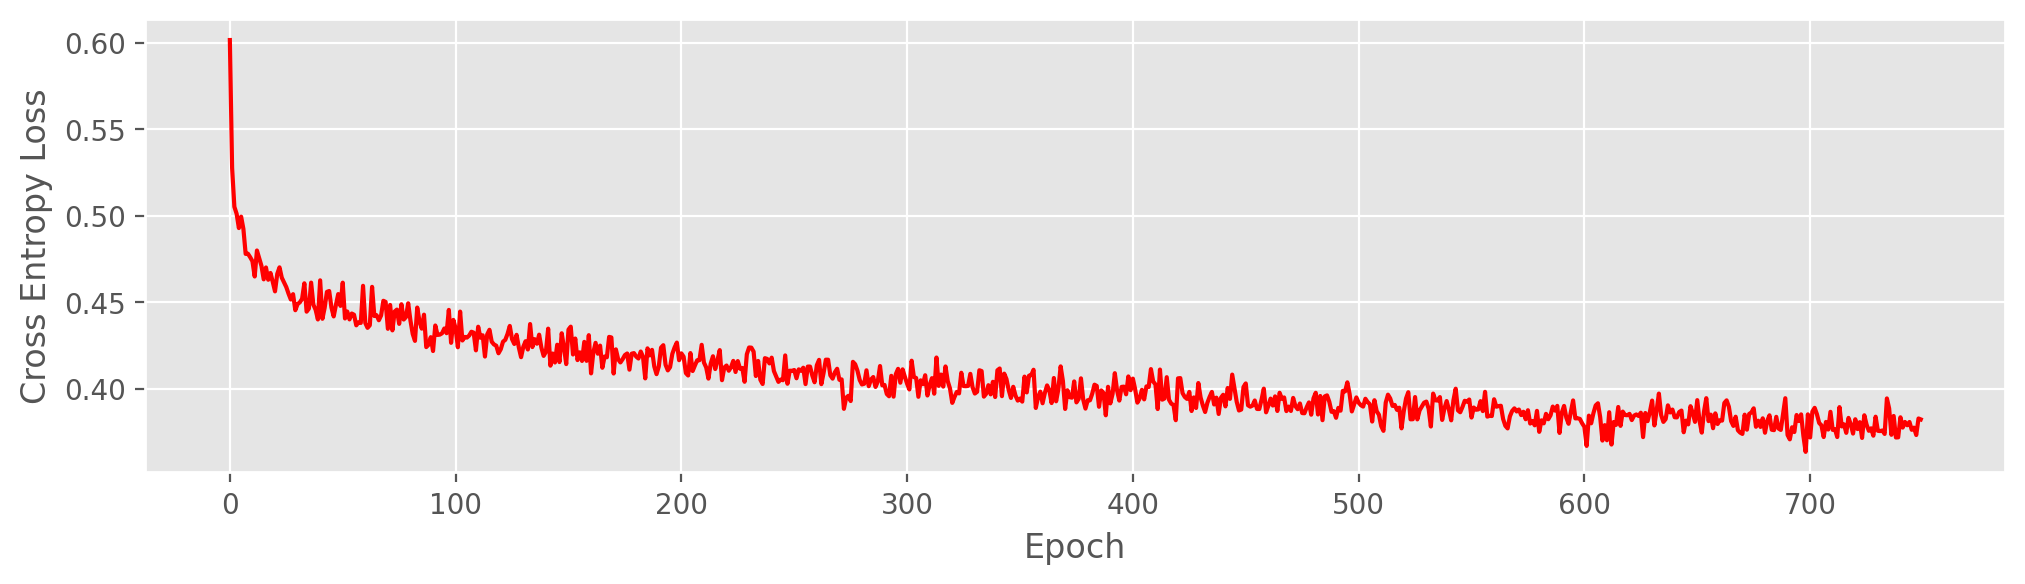

In [24]:
#Plot the losses and save the losses
fig , axes = plt.subplots(figsize=(12,3),dpi=200)

axes.plot(range(0,n_epochs), losses, 'r')
axes.set_xlabel('Epoch')
axes.set_ylabel('Cross Entropy Loss')

fig.savefig("Training Loss.png", dpi=200)

In [25]:
X_test     = df_test.values
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=False) 
with torch.no_grad():                                                  # Turn off the gradient update
    test_result = model(X_test_var)
values, labels = torch.max(test_result,1)
survived       = labels.data.numpy()

# Submission

In [26]:
submission = pd.DataFrame({'PassengerId':df_sub['PassengerId'],'Survived':survived})
submission.to_csv('submission.csv',index=False)